## TP3  - Computer Vision

In [14]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

In [15]:
path_images = r'C:\Users\Leandro\Documents\GitHub\vision_computadora_I\Material_TPs\TP3\images'
path_template = r'C:\Users\Leandro\Documents\GitHub\vision_computadora_I\Material_TPs\TP3\template'

In [16]:
images = ['\coca_logo_1.png', 
          '\coca_logo_2.png', 
          '\coca_multi.png',
          '\coca_retro_1.png',
          '\coca_retro_2.png',
          '\COCA-COLA-LOGO.jpg',
          '\logo_1.png']

template = ['\pattern.png']

In [17]:
# Cargo las imágenes
img_1 = cv.imread(path_images + images[0])
img_2 = cv.imread(path_images + images[1])
img_3 = cv.imread(path_images + images[2])
img_4 = cv.imread(path_images + images[3])
img_5 = cv.imread(path_images + images[4])
img_6 = cv.imread(path_images + images[5])
img_7 = cv.imread(path_images + images[6])

In [18]:
# Cargo el template
temp = cv.imread(path_template + template[0])

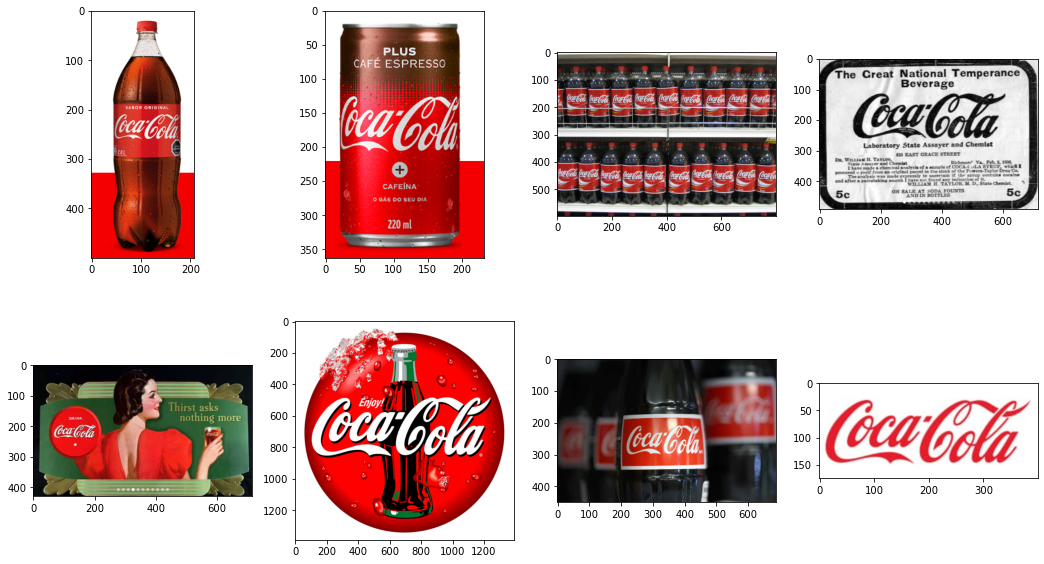

In [19]:
# Muestro las imágenes
fig, axs = plt.subplots(2, 4, figsize = (18, 10))
axs[0,0].imshow(img_1[:,:,::-1])
axs[0,1].imshow(img_2[:,:,::-1])
axs[0,2].imshow(img_3[:,:,::-1])
axs[0,3].imshow(img_4[:,:,::-1])
axs[1,0].imshow(img_5[:,:,::-1])
axs[1,1].imshow(img_6[:,:,::-1])
axs[1,2].imshow(img_7[:,:,::-1])
axs[1,3].imshow(temp[:,:,::-1])
plt.show()

#### 1) Obtener una detección del logo en cada imagen sin falsos positivos. (4 puntos)

In [20]:
def single_logo_detection(img):
    temp0 = cv.imread(path_template + template[0], 0)
    
    # Aplicar el filtro de mediana
    temp_median = cv.medianBlur(temp0, 9)
    edges_temp = cv.Canny(temp_median, 20, 60, L2gradient = True)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_median = cv.medianBlur(img_gray, 13)
    edges_img = cv.Canny(img_median, 150, 200, L2gradient = True)
    
    d1 = temp0.shape[0]
    d2 = temp0.shape[1]
    e1 = img.shape[0]
    e2 = img.shape[1]
    
    ratio1 = d1 / e1
    ratio2 = d2 / e2
    
    max_ratio = max(ratio1, ratio2)
    
    max_scale = 1 / max_ratio * 0.95
    min_scale = max_scale / 14
    
    K = np.linspace(min_scale, max_scale, 20)
    
    temps = []
    for k in K:
        resized_img = cv.resize(edges_temp, (int(d2 * k), int(d1 * k)), interpolation = cv.INTER_LINEAR)
        temps.append(resized_img)
    
    ### ---------------- ###
    res_list = []
    full_res_list = []
    metric_list = []
    
    # Los 6 métodos posibles para comparación:
    i = 0
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
                'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    n = 0
    for temp in temps:
        
        w, h = temp.shape[::-1]
           
        # Hacemos una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
        img_salida = img_rgb.copy()
        
        method = eval(methods[i])
        
        # Aplicamos la coincidencia de patrones
        res = cv.matchTemplate(edges_img, temp, method)
        
        # Encontramos los valores máximos y mínimos
        #c = int(temp.shape[0]/300)
        c = 20
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        m1 = np.mean(res[max_loc[1] - int(c/2):max_loc[1] + int(c), max_loc[0] - int(c):max_loc[0] + int(2*c)])
        m2 = np.sum(res[min_loc[1] - int(c):min_loc[1] + int(c), min_loc[0] - int(c):min_loc[0] + int(c)])
        metric = m1 / (temp.shape[0] * temp.shape[1])
        r = min_val, max_val, min_loc, max_loc, metric, w, h
        n = n + 1
        
        full_res_list.append(res)
        res_list.append(r)
        metric_list.append(metric)
        
    index = np.nanargmax(np.array(res_list, dtype = object).T[4])
    min_val, max_val, min_loc, max_loc, metric, w, h = res_list[index]
    
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    
    # Marcamos el lugar donde lo haya encontrado
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
    
    fig, axs = plt.subplots(1, 2, figsize = (10, 10))
        
    # Muestramos las imágenes
    axs[0].imshow(full_res_list[index], cmap = 'gray')
    axs[0].set_title(methods[i])
    axs[1].imshow(img_salida)
    axs[1].set_title(f'Confianza: {np.round(metric_list[index], 2)}')
    
    print(f'Lista de scores: \n {np.round(metric_list,2)}')
        
    plt.show()

Primero utilizo un filtro de mediana y luego aplico Canny. Luego, creo un vector de 20 tamaños de template con la condición de que ninguno de ellos sea más grande que la imagen original, para que el algoritmo no arroje error. Evalúo todos los templates, obtengo la posición de la máxima correlación y saco el promedio de esos valores en un radio de 10 píxeles. Luego divido ese valor promedio de correlación por la dimensiones del template. Esto lo hago porque cuanto más grande el template, tiene más valores para multiplicar y es lógico que el número sea mayor.Finalmente, me quedo con el número mayor.

Lista de scores: 
 [ 0.13 -1.91  6.81 10.48  5.12 34.08 15.83 17.58 49.92 55.78 49.05   nan
   nan 52.71   nan 50.76 61.82 66.42 80.79 81.26]


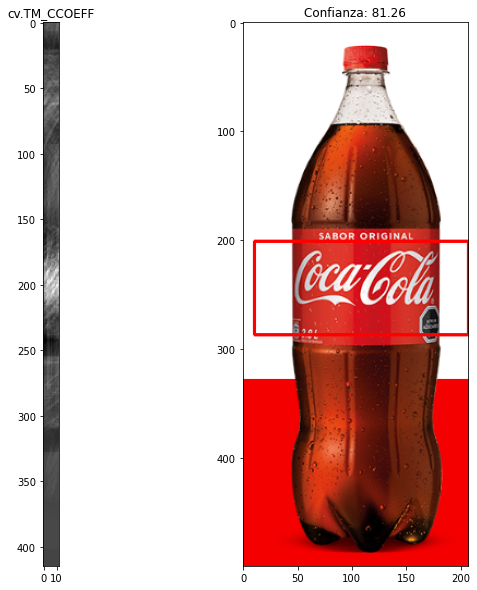

Lista de scores: 
 [ -1.34   0.27  13.06  13.46  -0.57  27.82    nan  47.91  49.38  51.06
  67.89  39.84    nan    nan  60.87  68.42  81.45  94.7  107.24 125.95]


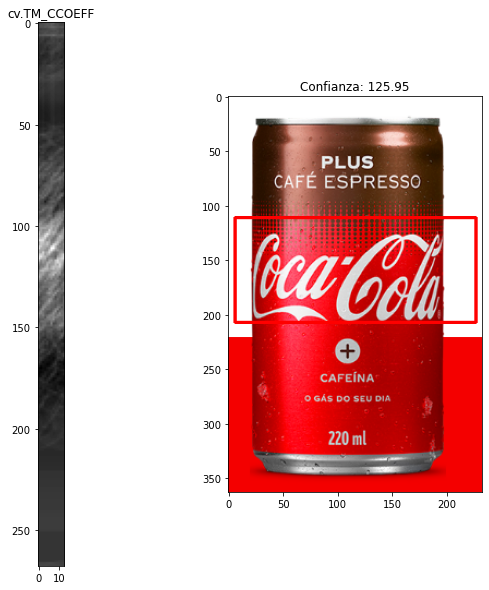

Lista de scores: 
 [ 2.6  12.41 25.9  31.32 31.11 33.48 36.9  31.7  22.    7.58 13.43 11.01
 19.62 20.88 30.29 29.63 25.95   nan 21.85 20.44]


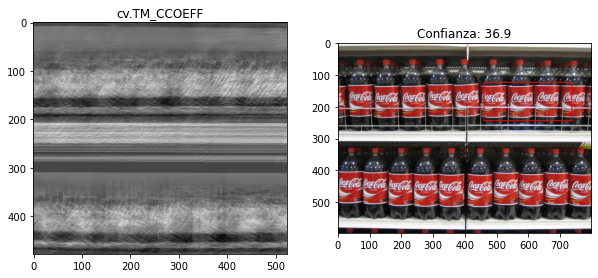

Lista de scores: 
 [ 7.13 35.55  3.6  65.19 59.45 49.03 32.3  31.54 39.51 34.82 51.7  69.4
 64.52 80.02 93.25 90.13 92.4  84.3  59.   40.71]


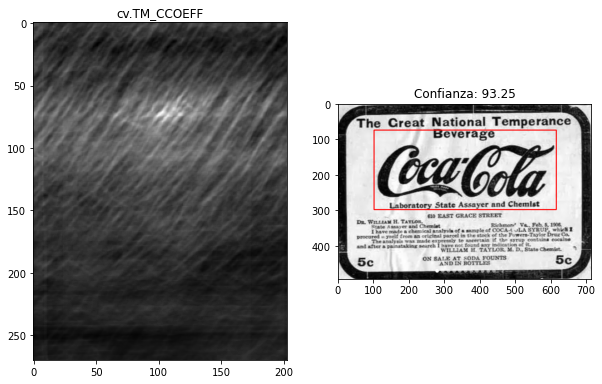

Lista de scores: 
 [-3.44 23.04 36.76 51.74 28.14 11.43   nan 17.97 15.64  9.9   5.21 16.26
  9.69 11.46   nan   nan   nan   nan   nan   nan]


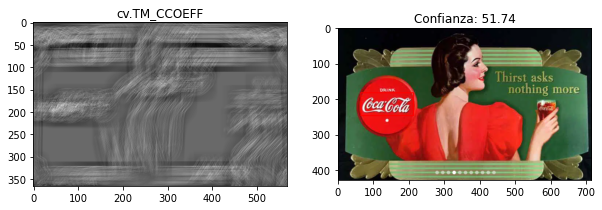

Lista de scores: 
 [ 9.48 47.73 24.7  18.4   4.85  5.87 27.51 16.31 50.61 42.79 31.28 22.51
 39.65 37.81 37.64 52.06 55.28 74.2  88.46 84.12]


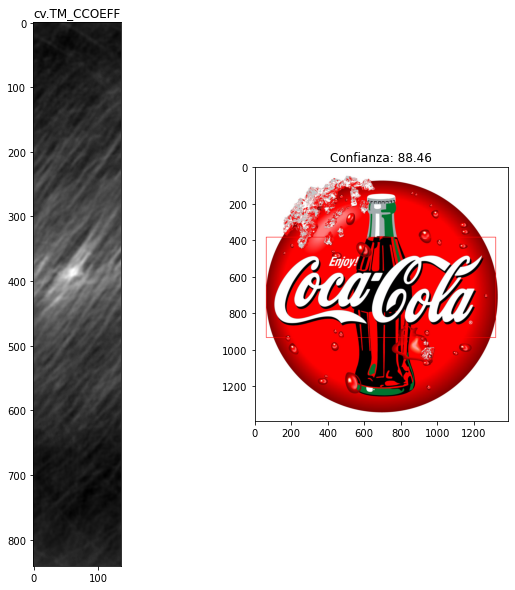

Lista de scores: 
 [15.15  3.25 32.11 43.37 39.31 50.23 62.58 68.37 66.04 56.59 45.58 16.83
 45.09   nan 46.52   nan   nan 33.72 35.34 36.31]


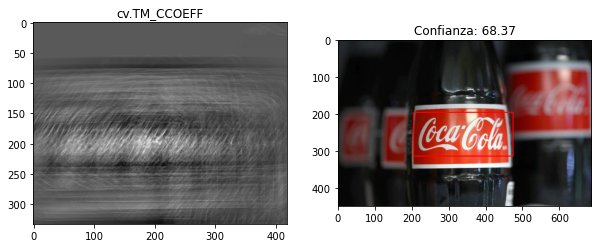

In [21]:
images = [img_1, img_2, img_3, img_4, img_5, img_6, img_7]
for img in images:
    single_logo_detection(img)

#### 2) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo template del item 2. (4 puntos)

In [24]:
def multiple_logo_detection(img, show = True, vals = False):
    temp0 = cv.imread(path_template + template[0], 0)
    
    # Aplicar el filtro de mediana
    temp_median = cv.medianBlur(temp0, 11)
    edges_temp = cv.Canny(temp_median, 100, 150, L2gradient = True)
    
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_median = cv.medianBlur(img_gray, 11)
    edges_img = cv.Canny(img_median, 100, 150, L2gradient = True)
    
    max_values = []
    max_locs = []
    
    # Los 6 métodos posibles para comparación:
    i = 0
    n = 0
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
                'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    
    factor = 0.22
    
    d1 = temp0.shape[0]
    d2 = temp0.shape[1]
    
    res_list = []
    temp = cv.resize(edges_temp, (int(d2 * factor), int(d1 * factor)), interpolation = cv.INTER_LINEAR)
    matches = np.arange(7)
    
    w, h = temp.shape[::-1]
       
    # Hacemos una copia de la imagen porque ciclo a ciclo le dibujo rectángulos
    img_salida = img_rgb.copy()
    
    method = eval(methods[i])
    
    # Aplicamos la coincidencia de patrones
    res = cv.matchTemplate(edges_img, temp, method)
    if show == True:
        fig, axs = plt.subplots(1, 2, figsize = (10, 10))    
    for match in matches:
        # Encontramos los valores máximos y mínimos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        metric = max_val / (temp.shape[0] * temp.shape[1])
        r = min_val, max_val, min_loc, max_loc, metric, w, h
        n = n + 1
        
        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        
        # Marcamos el lugar donde lo haya encontrado
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv.rectangle(img_salida,top_left, bottom_right, 255, 2)
        
        if show == True:
            # Muestramos las imágenes
            axs[0].imshow(res, cmap = 'gray')
            axs[0].set_title(methods[i])
            axs[1].imshow(img_salida)
        
        max_values.append(max_val)
        max_locs.append(max_loc)
    
        res[max_loc[1]-temp.shape[0]:max_loc[1]+temp.shape[0], max_loc[0]-temp.shape[1]:max_loc[0]+temp.shape[1]] = 0   
    
    plt.show()
    if vals == True:
        return max_values

Primero utilizo un filtro de mediana y luego aplico Canny. Luego, evalúo el template en la imagen y me quedo con la posición cuya correlación sea mayor. Posteriormente reemplazo en la imagen de correlaciones a dichos valores por 0, para que en la próxima iteración no vuelva a tomarlos y escoja el próxima valor máximo. Repito esto varias veces y obtengo todas esas detecciones.

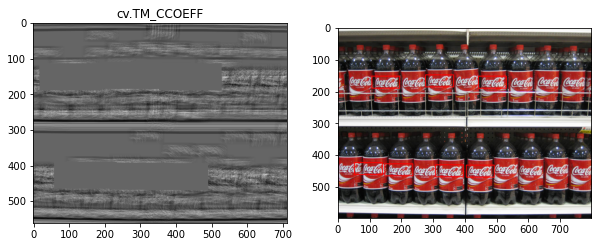

In [25]:
multiple_logo_detection(img_3)

#### 3) Generalizar el algoritmo del item 2 para todas las imágenes. (2 puntos)

In [26]:
def generalized_logo_detection(img):
    m = np.mean(multiple_logo_detection(img, show = False, vals = True))
    std = np.std(np.array(list(set(multiple_logo_detection(img, show = False, vals = True)))))
    c = len(set(multiple_logo_detection(img, show = False, vals = True)))
    r = std/c/m
    if r <= 0.015 and r != 0:
        multiple_logo_detection(img)
    else:
        single_logo_detection(img)

Acá, para elegir si utilizar múltiples detecciones o simples, creo una métrica que obtenga el promedio de todas las correlaciones múltiples de la imagen. Luego calculo el desvío estándar de esas correlaciones para ver cómo es su dispersión, y finalmente calculo la cantidad de detecciones.
La métrica la llamo 'r' y la calculo como un valor que es directamente proporcional al desvío estándar (porque si hay múltiples correlaciones, espero que sean todas muy parecidas, y el desvío estándar será menor), e inversamente proporcional al valor promedio y a la cantidad de detecciones (porque si tiene múltiples detecciones, se dividirá por un valor más grande, y si el promedio de la correlación en mayor, se dividirá por un valor mayor). De esta manera, obtengo un valor pequeño para múltiples detecciones, y pongo un umbral de 0.015. A su vez, le dije que sea distinto de 0, porque si el desvío estándar es 0, significa que sólo tiene una muestra, o sea con sólo una detección, y eso no me interesa.

Lista de scores: 
 [ 0.13 -1.91  6.81 10.48  5.12 34.08 15.83 17.58 49.92 55.78 49.05   nan
   nan 52.71   nan 50.76 61.82 66.42 80.79 81.26]


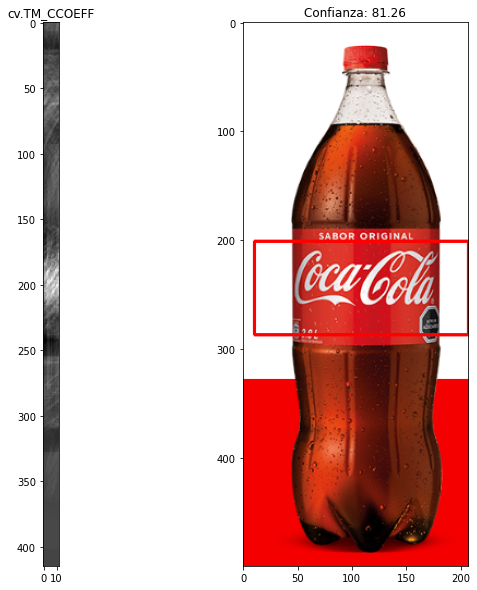

Lista de scores: 
 [ -1.34   0.27  13.06  13.46  -0.57  27.82    nan  47.91  49.38  51.06
  67.89  39.84    nan    nan  60.87  68.42  81.45  94.7  107.24 125.95]


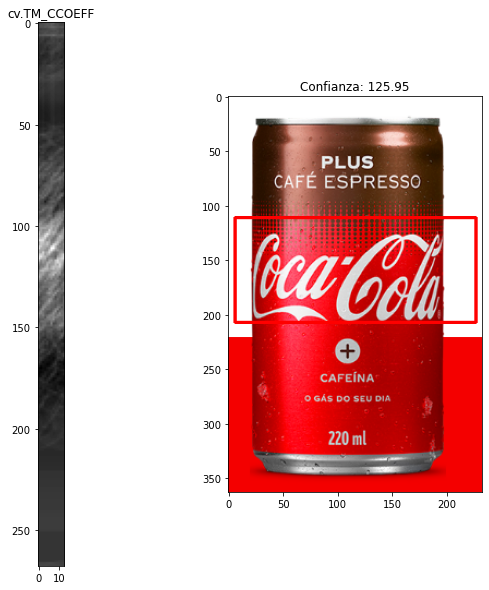

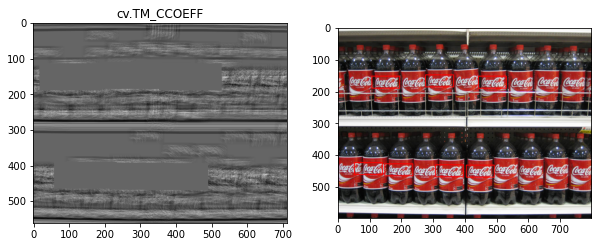

Lista de scores: 
 [ 7.13 35.55  3.6  65.19 59.45 49.03 32.3  31.54 39.51 34.82 51.7  69.4
 64.52 80.02 93.25 90.13 92.4  84.3  59.   40.71]


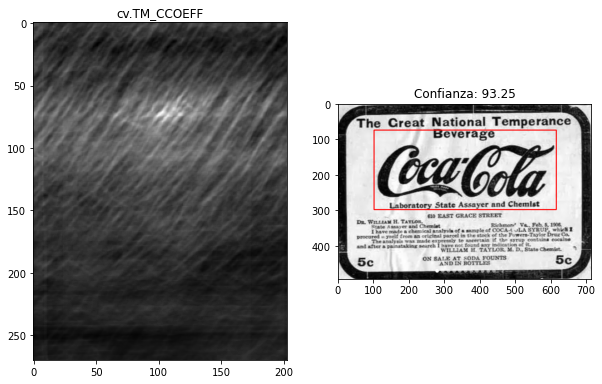

Lista de scores: 
 [-3.44 23.04 36.76 51.74 28.14 11.43   nan 17.97 15.64  9.9   5.21 16.26
  9.69 11.46   nan   nan   nan   nan   nan   nan]


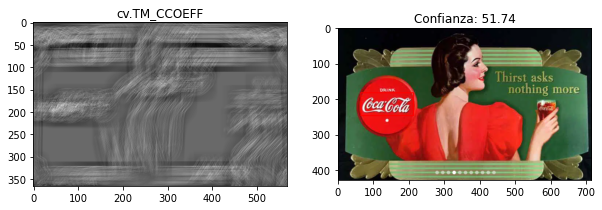

Lista de scores: 
 [ 9.48 47.73 24.7  18.4   4.85  5.87 27.51 16.31 50.61 42.79 31.28 22.51
 39.65 37.81 37.64 52.06 55.28 74.2  88.46 84.12]


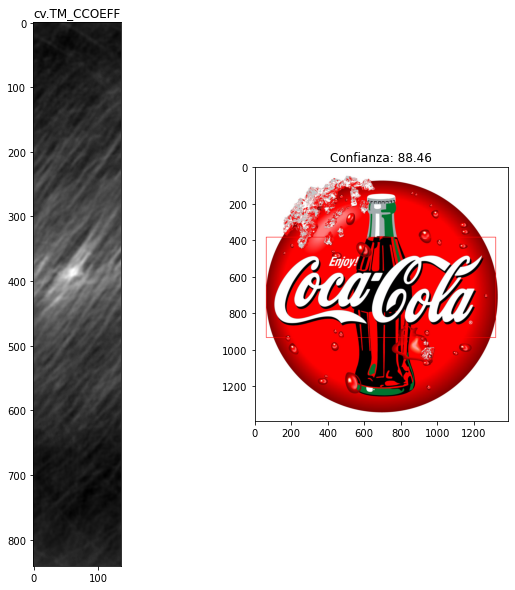

Lista de scores: 
 [15.15  3.25 32.11 43.37 39.31 50.23 62.58 68.37 66.04 56.59 45.58 16.83
 45.09   nan 46.52   nan   nan 33.72 35.34 36.31]


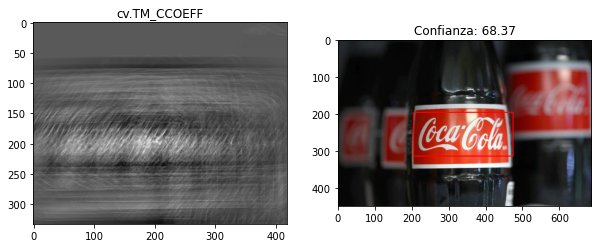

In [28]:
images = [img_1, img_2, img_3, img_4, img_5, img_6, img_7]
for img in images:
    generalized_logo_detection(img)